![](https://github.com/rajeevratan84/ModernComputerVision/raw/main/logo_MCV_W.png)

# **Googe Deep Dream in PyTorch**

---


In this lesson, we learn to implement the **Google Deep Dream Algorithm** using PyTorch. This method was first introduced by Alexander Mordvintsev from Google in July 2015.

It enables us to provide the 'Deep Dream' effect which produces hallucinogenic-like visuals. 

In this tutorial we:

1. Load Modules and pre-trained VGG Network
2. Get the output channels of a layer and run our Deep Dream algorithm
3. Improving Deep Dream by running it on different scales
4. Implement targeted Deep Dream

## **1. Load Modules and pre-trained VGG Network**

In [ ]:
import numpy as np
import torch
import torch.nn as nn
from torchvision import transforms
import torchvision.models as models

from PIL import Image, ImageFilter, ImageChops
import matplotlib.pyplot as plt

import requests
from io import BytesIO

vgg = models.vgg16(pretrained = True)
vgg = vgg.cuda()
vgg.eval()

#Input image
url = 'https://github.com/rajeevratan84/ModernComputerVision/raw/main/castara-tobago.jpeg'
response = requests.get(url)
img = Image.open(BytesIO(response.content))

from IPython.display import Image as Img

display(img)

## **2. Get the output channels of a layer**

Get the output channels of a layer and compute the gradients from its L2 norm. Use this data to update the input image, but moving its parameters in the gradient direction (instead of against it). Repeat!

https://www.kaggle.com/sironghuang/understanding-pytorch-hooks

In [ ]:
from PIL import Image
# Register a hook on the target layer (used to get the output channels of the layer)
class Hook():
    def __init__(self, module, backward=False):
        if backward==False:
            self.hook = module.register_forward_hook(self.hook_fn)
        else:
            self.hook = module.register_backward_hook(self.hook_fn)
    def hook_fn(self, module, input, output):
        self.input = input
        self.output = output
    def close(self):
        self.hook.remove()
  
# Make gradients calculations from the output channels of the target layer  
def get_gradients(net_in, net, layer):     
  net_in = net_in.unsqueeze(0).cuda()
  net_in.requires_grad = True
  net.zero_grad()
  hook = Hook(layer)
  net_out = net(net_in)
  loss = hook.output[0].norm()
  loss.backward()
  return net_in.grad.data.squeeze()

# Denormalization image transform
denorm = transforms.Compose([ transforms.Normalize(mean = [ 0., 0., 0. ], std = [ 1/0.229, 1/0.224, 1/0.225 ]),                 
                              transforms.Normalize(mean = [ -0.485, -0.456, -0.406 ], std = [ 1., 1., 1. ]),                                                     
                              ])

# Run the Google Deep Dream.
def dream(image, net, layer, iterations, lr):
  image_tensor = transforms.ToTensor()(image)
  image_tensor = transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])(image_tensor).cuda()
  for i in range(iterations):
    gradients = get_gradients(image_tensor, net, layer)
    image_tensor.data = image_tensor.data + lr * gradients.data

  img_out = image_tensor.detach().cpu()
  img_out = denorm(img_out)
  img_out_np = img_out.numpy().transpose(1,2,0)
  img_out_np = np.clip(img_out_np, 0, 1)
  img_out_pil = Image.fromarray(np.uint8(img_out_np * 255))
  return img_out_pil

### **Run Our First Google Deep Dream**

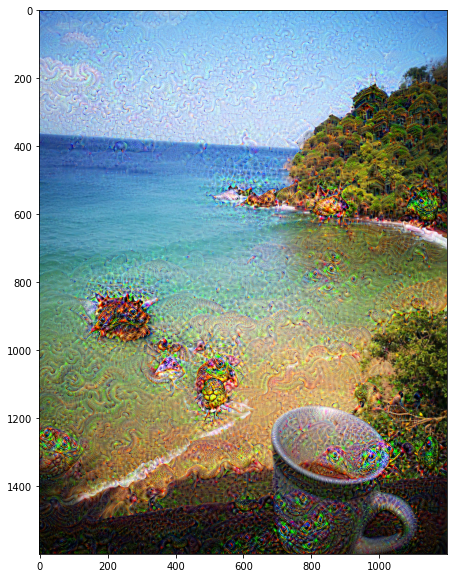

In [ ]:
orig_size = np.array(img.size)
new_size = np.array(img.size)*0.5
img = img.resize(new_size.astype(int))
layer = list( vgg.features.modules() )[27]

# Execute our Deep Dream Function 
img = dream(img, vgg, layer, 20, 1)

img = img.resize(orig_size)
fig = plt.figure(figsize = (10 , 10))
plt.imshow(img)

## **Improving Deep Dream**

We see that the patterns have the same scale, and the deep dream effect gets enhanced on the low resolution image. 

An update to the prior code is to run the dream function repeatedly, but everytime with the image resized to a different scale.

In [ ]:
# Make gradients calculations from the output channels of the target layer.
# Selection of which output channels of the layer can be done
def get_gradients(net_in, net, layer, out_channels = None):     
  net_in = net_in.unsqueeze(0).cuda()
  net_in.requires_grad = True
  net.zero_grad()
  hook = Hook(layer)
  net_out = net(net_in)
  if out_channels == None:
    loss = hook.output[0].norm()
  else:
    loss = hook.output[0][out_channels].norm()
  loss.backward()
  return net_in.grad.data.squeeze()

# Function to run the dream. The excesive casts to and from numpy arrays is to make use of the np.roll() function.
# By rolling the image randomly everytime the gradients are computed, we prevent a tile effect artifact from appearing.
def dream(image, net, layer, iterations, lr, out_channels = None):
  image_numpy = np.array(image)
  image_tensor = transforms.ToTensor()(image_numpy)
  image_tensor = transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])(image_tensor).cuda()
  denorm = transforms.Compose([ transforms.Normalize(mean = [ 0., 0., 0. ], std = [ 1/0.229, 1/0.224, 1/0.225 ]),                 
                                transforms.Normalize(mean = [ -0.485, -0.456, -0.406 ], std = [ 1., 1., 1. ]),                                                     
                               ])
  for i in range(iterations):
    roll_x = np.random.randint(image_numpy.shape[0])
    roll_y = np.random.randint(image_numpy.shape[1])
    img_roll = np.roll(np.roll(image_tensor.detach().cpu().numpy().transpose(1,2,0), roll_y, 0), roll_x, 1)
    img_roll_tensor = torch.tensor(img_roll.transpose(2,0,1), dtype = torch.float)
    gradients_np = get_gradients(img_roll_tensor, net, layer, out_channels).detach().cpu().numpy()
    gradients_np = np.roll(np.roll(gradients_np, -roll_y, 1), -roll_x, 2)
    gradients_tensor = torch.tensor(gradients_np).cuda()
    image_tensor.data = image_tensor.data + lr * gradients_tensor.data

  img_out = image_tensor.detach().cpu()
  img_out = denorm(img_out)
  img_out_np = img_out.numpy()
  img_out_np = img_out_np.transpose(1,2,0)
  img_out_np = np.clip(img_out_np, 0, 1)
  img_out_pil = Image.fromarray(np.uint8(img_out_np * 255))
  return img_out_pil

# Input image
url = 'https://github.com/rajeevratan84/ModernComputerVision/raw/main/castara-tobago.jpeg'
response = requests.get(url)
img = Image.open(BytesIO(response.content))
orig_size = np.array(img.size)
new_size = np.array(img.size)*0.5
#img = img.resize(new_size.astype(int))
layer = list( vgg.features.modules() )[27]

from IPython.display import Image as Img

display(img)

In [ ]:
# Visualize features at different scales, the image is resized multiple times and run thru the dream
OCTAVE_SCALE = 1.5
for n in range(-7,1):
  new_size = orig_size * (OCTAVE_SCALE**n)
  img = img.resize(new_size.astype(int), Image.ANTIALIAS)
  img = dream(img, vgg, layer, 50, 0.05, out_channels = None)

img = img.resize(orig_size)
fig = plt.figure(figsize = (10 , 10))
plt.imshow(img)

## **3.Targeted Deep Dream**

Here we guide the dream, using a target image with features we would like to visualize in our input image.

In [ ]:
def objective_guide(dst, guide_features):
    '''Our objective guide function'''
    x = dst.data[0].cpu().numpy().copy()
    y = guide_features.data[0].cpu().numpy()
    ch, w, h = x.shape

    x = x.reshape(ch,-1)
    y = y.reshape(ch,-1)
    A = x.T.dot(y) # compute the matrix of dot-products with guide features
    result = y[:,A.argmax(1)] # select ones that match best
    result = torch.Tensor(np.array([result.reshape(ch, w, h)], dtype=np.float)).cuda()
    return result        

# Now we can have guide features as an input
def get_gradients(net_in, net, layer, control = False, guide_features = None):     
  net_in = net_in.unsqueeze(0).cuda()
  net_in.requires_grad = True
  net.zero_grad()
  hook = Hook(layer)
  net_out = net(net_in)
  if control:
    params = objective_guide(hook.output, guide_features)[0]
  else:
    params = hook.output[0]
  hook.output[0].backward( params )
  return net_in.grad.data.squeeze()
  
# Our new dream algorithm
def dream(image, net, layer, iterations, lr, control = False, guide_features = None):
  image_numpy = np.array(image)
  image_tensor = transforms.ToTensor()(image_numpy)
  image_tensor = transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])(image_tensor).cuda()
  denorm = transforms.Compose([ transforms.Normalize(mean = [ 0., 0., 0. ], std = [ 1/0.229, 1/0.224, 1/0.225 ]),                 
                                transforms.Normalize(mean = [ -0.485, -0.456, -0.406 ], std = [ 1., 1., 1. ]),                                                     
                               ])
  for i in range(iterations):
    roll_x = np.random.randint(image_numpy.shape[0])
    roll_y = np.random.randint(image_numpy.shape[1])
    img_roll = np.roll(np.roll(image_tensor.detach().cpu().numpy().transpose(1,2,0), roll_y, 0), roll_x, 1)
    img_roll_tensor = torch.tensor(img_roll.transpose(2,0,1), dtype = torch.float)
    gradients_np = get_gradients(img_roll_tensor, net, layer, control, guide_features).detach().cpu().numpy()
    gradients_np = np.roll(np.roll(gradients_np, -roll_y, 1), -roll_x, 2)
    ratio = np.abs(gradients_np.mean())
    lr_ = lr / ratio
    lr_ = lr
    gradients_tensor = torch.tensor(gradients_np).cuda()
    image_tensor.data = image_tensor.data + lr_ * gradients_tensor.data
  img_out = image_tensor.detach().cpu()
  img_out = denorm(img_out)
  img_out_np = img_out.numpy()
  img_out_np = img_out_np.transpose(1,2,0)
  img_out_np = np.clip(img_out_np, 0, 1)
  img_out_pil = Image.fromarray(np.uint8(img_out_np * 255))
  return img_out_pil

layer = list( vgg.features.modules() )[33]

# extract target features
url_guide_features = "https://www.allfordogs.org/wp-content/uploads/2018/05/many-dog-faces.jpg"
response = requests.get(url_guide_features)
features_img = Image.open(BytesIO(response.content))
new_size = np.array(features_img.size)*1.5
features_img = features_img.resize(new_size.astype(int))

img_np = np.array(features_img)
img_tensor = transforms.ToTensor()(img_np)
hook = Hook(layer)
net_out = vgg(img_tensor.unsqueeze(0).cuda())
guide_features = hook.output

#input image
url = "https://github.com/rajeevratan84/ModernComputerVision/raw/main/castara-tobago.jpeg"
response = requests.get(url)
img = Image.open(BytesIO(response.content))
new_size = np.array(img.size)*0.5
img = img.resize(new_size.astype(int))
og_size = np.array(img.size)

OCTAVE_SCALE = 1.3
for n in range(-7,0):
  new_size = og_size * (OCTAVE_SCALE**n)
  img = img.resize(new_size.astype(int), Image.ANTIALIAS)
  img = dream(img, vgg, layer, 100, 0.00005, control = True, guide_features = guide_features)

img = img.resize(og_size)
fig = plt.figure(figsize = (10 , 10))
plt.imshow(img)